# Dactylic Verse

There are three main places where a break (caesura) can break up the hexamter into two smaller units.

||1|2|3|4|5|6||
| :---|:--:|:--:| :--:| :--:| :--:|:--:| --:| 
|1.| – ⏔| – ⏔| **– ┇⏔** |– ⏔| – ⏔| – –|penthemimeral caesura|
|2.| – ⏔| – ⏔| **– ⏑┇⏑** |– ⏔| – ⏔| – –|trochaic caesura|
|3.| – ⏔| – ⏔| –  ⏔ |**– ┇ ⏔**| – ⏔| – –|hephthemimeral caesura|


In [2]:
import re

# load in data from the Homer Treebanks

## you can get this data with wget from https://github.com/gregorycrane/gAGDT

form2lemmas = {}
lemma2forms = {}
lemma2formcnts = {}
form2pos = {}
eachform2lemma = {}
eachform2pos = {}
formindex = {}
lemmaindex = {}
lemmacnt = {}
multilemmas = ["ὁ","ὅς"]
def gettreebankdata(fname):
    f = open(fname)
    curlemma = ''
    curform = ''
    curcite = ''
    curpos = ''
    for l in f:
        if( not re.search('<word',l)):
            continue
        m = re.search('cite="urn:cts:greekLit:tlg0012\.([^"]+)"',l)
        if(m):
            curcite = m[1]
        m = re.search('postag="([^"]+)"',l)
        if(m):
            curpos = m[1]
            curpos = re.sub("'","’",curpos)
        m = re.search('form="([^"]+)"',l)
        if(m):
            curform = m[1]
            curform = re.sub("'","’",curform)
        m = re.search('lemma="([^"]+)"',l)
        if(m):
            curlemma = m[1]
            
        if(curform and curcite):
            if(curlemma in lemmaindex):
                lemmaindex[curlemma].append(curcite)
                lemmacnt[curlemma] = lemmacnt[curlemma] + 1

            else:
                lemmacnt[curlemma] =  1

                lemmaindex[curlemma] = [curcite]
            if(curform in formindex):
                lemmaindex[curlemma].append(curcite)

            else:
                
                formindex[curform] = [curcite]
                
        if(re.search('artificial',l)):
            continue
        formkey = curpos + '\t' + curform
        if(curlemma in lemma2forms):
            curdict = lemma2forms[curlemma]
            if(formkey in curdict):
                curdict[formkey] = curdict[formkey] + 1
            else:
                lemma2formcnts[curlemma] = lemma2formcnts[curlemma] + 1
                curdict[formkey] = 1
            lemma2forms[curlemma] = curdict
        else:
            lemma2formcnts[curlemma] =  1
            lemma2forms[curlemma] = { formkey : 1}

        if(curform and curlemma):
            #if(curform in form2lemmas and not curlemma == form2lemmas[curform] and not curlemma in multilemmas):
            #    print('altlemma',form2lemmas[curform],l)
            form2lemmas[curform] = curlemma
            form2pos[curform] = curpos
        curkey = curcite + '\t' + curform
        eachform2lemma[curkey] = curlemma
        eachform2pos[curkey] = curpos
            
    f.close()


gettreebankdata('/Users/gcrane/github/gAGDT/data/xml/tlg0012.tlg001.perseus-grc1.tb.xml')
gettreebankdata('/Users/gcrane/github/gAGDT/data/xml/tlg0012.tlg002.perseus-grc1.tb.xml')
print('got treebank data')

got treebank data


In [3]:
formindex['μῆνις']

['tlg001:15.122']

In [4]:

import re
from tabulate import tabulate


caesurashapes = {'caesmasc3' : ' – ⏔ – ⏔ – | ⏔ – ⏔ – ⏔ – –', 'caesfem3': '– ⏔ – ⏔ – ⏑ | ⏑ – ⏔ – ⏔ – –','caesmasc4' : ' – ⏔ – ⏔ – ⏔ – | ⏔ – ⏔ – –', 'caesfem4': '– ⏔ – ⏔ – ⏔ – ⏑ | ⏑  – ⏔ – –', 'nocaes': '– ⏔ – ⏔ – ⏔ – ⏔ – ⏔ – –' }
diaeresisshapes = {'diaer2' : '– ⏔ | – ⏔ – ⏔ – ⏔ – ⏔ – –', 'diaer3' : '– ⏔ – ⏔ | – ⏔ – ⏔ – ⏔ – –', 'diaer4': '– ⏔ – ⏔ – ⏔ | – ⏔ – ⏔ – –', 'bucdiaer': '– ⏔ – ⏔ – ⏔ – ⏔ | – ⏔ – –', 'diaer6': '– ⏔ – ⏔ – ⏔ – ⏔ – ⏔ | – –' }
otherfeatures = ['long2short','short2long','hiatus','shortdouble','shorttriple','noelis','synizesis']
caesuraexamples = {}
diaeresisexamples = {}
all_words = []
full_lines = {}
meter_lines = {}
justscan_lines = {}
genericfoot = '– ⏔'
genericline = [genericfoot,genericfoot,genericfoot,genericfoot,genericfoot,'– –']


for foo in caesurashapes:
    caesuraexamples[foo] = []
    
for foo in diaeresisshapes:
    diaeresisexamples[foo] = []
    
def getmeterstats(fname):
    caesuras = {}
    diaereses = {}
    curhemi = ''
    prevhemi = ''
    prevline = ''
    curline = ''
    linecnt = 0
    for foo in caesurashapes:
        caesuras[foo] = 0
    for foo in diaeresisshapes:
        diaereses[foo] = 0
    othercounts = {}
    for foo in otherfeatures:
        othercounts[foo] = 0
    f = open(fname)
    for l in f:
        
        args = l.split()
        if(len(args) == 0):
            continue
        if(re.search('#',l)):
            continue
        all_words.append(re.sub('\n','',l))
        for curcaes in caesurashapes:
            if(re.search(curcaes,l)):
                caesuras[curcaes] = caesuras[curcaes] + 1
                caesuraexamples[curcaes].append(args[0])
        for curcaes in diaeresisshapes:
            if(re.search(curcaes,l)):
                diaereses[curcaes] = diaereses[curcaes] + 1
                diaeresisexamples[curcaes].append(args[0])
        for curcaes in otherfeatures:
            if(re.search(curcaes,l)):
                othercounts[curcaes] = othercounts[curcaes] + 1
        curline = args[0]
        if(not curline == prevline):
            linecnt = linecnt + 1
            full_lines[curline] = args[1]
            meter_lines[curline] = args[4]
        else:
            full_lines[curline] = full_lines[curline] + ' ' + args[1]
            meter_lines[curline] = meter_lines[curline] + ' ' + args[4]
        if(not curline == prevline and curhemi == 'hemi1'):
            caesuras['nocaes'] = caesuras['nocaes'] + 1
            caesuraexamples['nocaes'].append(prevline)

        curhemi = args[5]
        prevline = curline
        prevhemi = curhemi
    return(caesuras,diaereses,othercounts,linecnt)
            
    
    f.close()


iliadcaesuras,ildiaereses,ilother,illinecnt = getmeterstats('caesura.tlg0012.tlg001.meter.tsv')
odysseycaesuras,oddiaereses,odother,odlinecnt = getmeterstats('caesura.tlg0012.tlg002.meter.tsv')

for foo in meter_lines:
    justscan = re.sub('(-long-|long-)','L',meter_lines[foo])
    justscan = re.sub('(-short-|short-)','S',justscan)
    justscan = re.sub('[^LS]','',justscan)
    justscan = re.sub('LSS','\tL S S',justscan)
    justscan = re.sub('LL','\tL L',justscan)
    justscan = re.sub('^\s+','',justscan)
    justscan = re.sub('L','–',justscan)
    justscan = re.sub('S','⏑',justscan)
    footlist = justscan.split('\t')
    justscan_lines[foo] = footlist


print('done')


    


done


#  Spondees in different feet of the hexameter

In any of the first five feet of the hexameter, we can find either a dactyl (– ⏑⏑) or a spondee (– –), but the data shows two tendencies:

* Dactyls are more common than spondees in every part of the hexameter.
* The frequency of spondees varies widely in different parts of the hexameter from 40% to 5%.

## Monro 366. https://dcc.dickinson.edu/grammar/monro/hexameter

"The fifth thesis nearly always consists of two short syllables, thus producing the characteristic ˉ ˘ ˘ ˉ ˉ̆ which marks the end of each hexameter." -- **nearly always.**

## Raven 56.

"the spondee is rare in the fifth place. The last metron must be a spondee." -- **rare.**

## Maas/Lloyd-Jones 82-83.

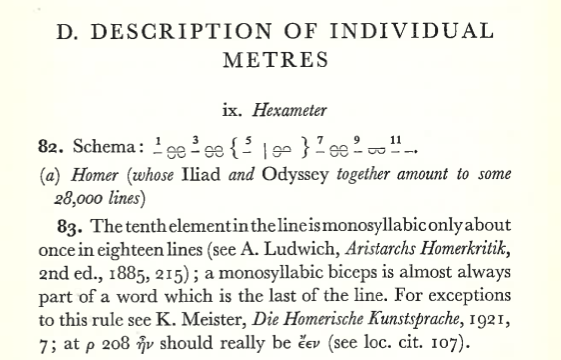

-- **only about once in eighteen lines.**

In [5]:
spondeelines = {}

spondeefreq = {}
for i in range(0,5):
    spondeefreq[i] = 0
    spondeelines[i] = []
    
for foo in justscan_lines:
    for i in range(0,5):
        #print(foo,foo[i])
        if(justscan_lines[foo][i] == '– –'):
            spondeefreq[i] = spondeefreq[i] + 1
            spondeelines[i].append(foo)

i = 0
cumpercent = 1
printlist = []
for foo in spondeefreq:
    metline = []
    for foo in genericline:
        metline.append(foo)
    metline[i] = '– –'
    cumpercent = spondeefreq[i]/(illinecnt+odlinecnt) * cumpercent
    totpercent = re.sub('(\.[0-9][0-9])[0-9]*','\g<1>',str(100*spondeefreq[i]/(illinecnt+odlinecnt)) + '%')

    #print(i+1,metline,spondeefreq[i],totpercent)
    printlist.append([i+1,metline,spondeefreq[i],totpercent])
    i = i + 1
    
print()
print(tabulate(printlist,headers=['Foot','Pattern','Frequency','%']))
#print(spondeelines[4])


  Foot  Pattern                                       Frequency  %
------  ------------------------------------------  -----------  ------
     1  ['– –', '– ⏔', '– ⏔', '– ⏔', '– ⏔', '– –']        10550  37.96%
     2  ['– ⏔', '– –', '– ⏔', '– ⏔', '– ⏔', '– –']        11251  40.48%
     3  ['– ⏔', '– ⏔', '– –', '– ⏔', '– ⏔', '– –']         4407  15.85%
     4  ['– ⏔', '– ⏔', '– ⏔', '– –', '– ⏔', '– –']         8250  29.68%
     5  ['– ⏔', '– ⏔', '– ⏔', '– ⏔', '– –', '– –']         1419  5.10%


Maas states that the fifth foot has a spondee about "only about once in eighteen lines." This is close, but the actual figure is one in 20.

Monro: https://dcc.dickinson.edu/grammar/monro/hexameter
366. The verse in which the Homeric poems are composed—the heroic hexameter—consists of six feet, of equal length, each of which again is divided into two equal parts, viz. an accented part or arsis (on which the rhythmical beat or ictus falls), and an unaccented part or thesis. In each foot the arsis consists of one long syllable, the thesis of one long or two short syllables; except the last thesis, which consists of one syllable, either long or short.

    The fifth thesis nearly always consists of two short syllables, thus producing the characteristic – ⏑ ⏑	– – which marks the end of each hexameter.

    The last foot is probably to be regarded as a little shorter than the others, the time being filled up by the pause at the end of the verse. The effect of this shortening is heightened by the dactyl in the fifth place, since the two short syllables take the full time of half a foot.

In [6]:
i = 0
hasbreak = 0
spondeeline = 0
lDll = 0
lDll_lines = []
for foo in spondeelines[4]:
    justmeter = re.sub('[^longshort\- ]','',meter_lines[foo])
    m = re.search('(long[^a-z]+long[^a-z]+long[^a-z])$',justmeter)
    
    if(m):
        curspondee = m[1]
        spondeeline = spondeeline + 1
        if(re.search(' ',curspondee)):
            hasbreak = hasbreak + 1
        
            print('break',foo,full_lines[foo])
        #else:
            #print('nobreak',foo,full_lines[foo])
        if(re.search('\s[^a-z]*long[^a-z]+long[^a-z]*$',curspondee)):
            #print('LL+DIAER+LL$',foo,full_lines[foo])
            lDll = lDll + 1
            lDll_lines.append(foo)

        i = i + 1
        #print(justmeter)
        #print(full_lines[foo])
spondeewordsendsline = re.sub('(\.[0-9]).+','\g<1>',str(100*(spondeeline-hasbreak)/spondeeline))
print("spondeelines",spondeeline,hasbreak,spondeewordsendsline+'%')

i = 0
for foo in lDll_lines:
    i = i + 1
    print(i,'lDll',foo,full_lines[foo])

ldllpercent = re.sub('(\.[0-9][0-9]).+','\g<1>',str(100*lDll/(ildiaereses['diaer6']+oddiaereses['diaer6']))) +'%'
print(lDll,ildiaereses['diaer6'],oddiaereses['diaer6'],ildiaereses['diaer6']+oddiaereses['diaer6'],ldllpercent)



break tlg001:1.333 αὐτὰρ ὃ ἔγνω ᾗσιν ἐνὶ φρεσὶ φώνησέν τε·
break tlg001:1.425 δωδεκάτῃ δέ τοι αὖτις ἐλεύσεται Οὔλυμπον δέ,
break tlg001:1.497 ἠερίη δ’ ἀνέβη μέγαν οὐρανὸν Οὔλυμπόν τε.
break tlg001:2.123 εἴ περ γάρ κ’ ἐθέλοιμεν Ἀχαιοί τε Τρῶές τε
break tlg001:2.268 σκήπτρου ὕπο χρυσέου· ὃ δ’ ἄρ’ ἕζετο τάρβησέν τε,
break tlg001:2.764 τὰς Εὔμηλος ἔλαυνε ποδώκεας ὄρνιθας ὣς
break tlg001:3.2 Τρῶες μὲν κλαγγῇ τ’ ἐνοπῇ τ’ ἴσαν ὄρνιθες ὣς
break tlg001:3.111 Ὣς ἔφαθ’, οἳ δ’ ἐχάρησαν Ἀχαιοί τε Τρῶές τε
break tlg001:3.172 αἰδοῖός τέ μοί ἐσσι φίλε ἑκυρὲ δεινός τε·
break tlg001:3.181 Ὣς φάτο, τὸν δ’ ὁ γέρων ἠγάσσατο φώνησέν τε·
break tlg001:3.297 Ὧδε δέ τις εἴπεσκεν Ἀχαιῶν τε Τρώων τε·
break tlg001:3.319 ὧδε δέ τις εἴπεσκεν Ἀχαιῶν τε Τρώων τε·
break tlg001:4.85 Ὣς ἄρα τις εἴπεσκεν Ἀχαιῶν τε Τρώων τε.
break tlg001:4.182 Ὥς ποτέ τις ἐρέει· τότε μοι χάνοι εὐρεῖα χθών.
break tlg001:4.482 ἦλθεν· ὃ δ’ ἐν κονίῃσι χαμαὶ πέσεν αἴγειρος ὣς
break tlg001:5.448 ἐν μεγάλῳ ἀδύτῳ ἀκέοντό τε κύδαινόν τε·
break tlg0

In [7]:
totlines = 0
for foo in full_lines:
    if(re.search('tlg001:([0-9]|1[0-9]|20)\.',foo)):
        totlines = totlines + 1
print('totlines',totlines)
for i in range(0,5):
    curspondees = 0
    for foo in spondeelines[i]:
        if(re.search('tlg001:([0-9]|1[0-9]|20)\.',foo)):
            curspondees = curspondees + 1
    print('foot',i+1,curspondees,'spondees')

    

totlines 12855
foot 1 4946 spondees
foot 2 5098 spondees
foot 3 1968 spondees
foot 4 3813 spondees
foot 5 693 spondees


Meister HK p. 7: 
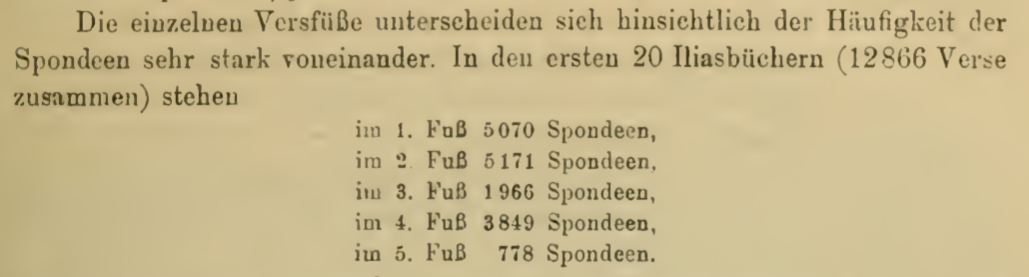
Same general picture but the precise figures differ slightly.

Maas 83: "a monosyllabic biceps is almost always part of a word which is the last of the line."
    
Maas is correct and the actual percentage is 91% (123 out of 1425).

Meister, Homerische Kunstsprache p. 7:

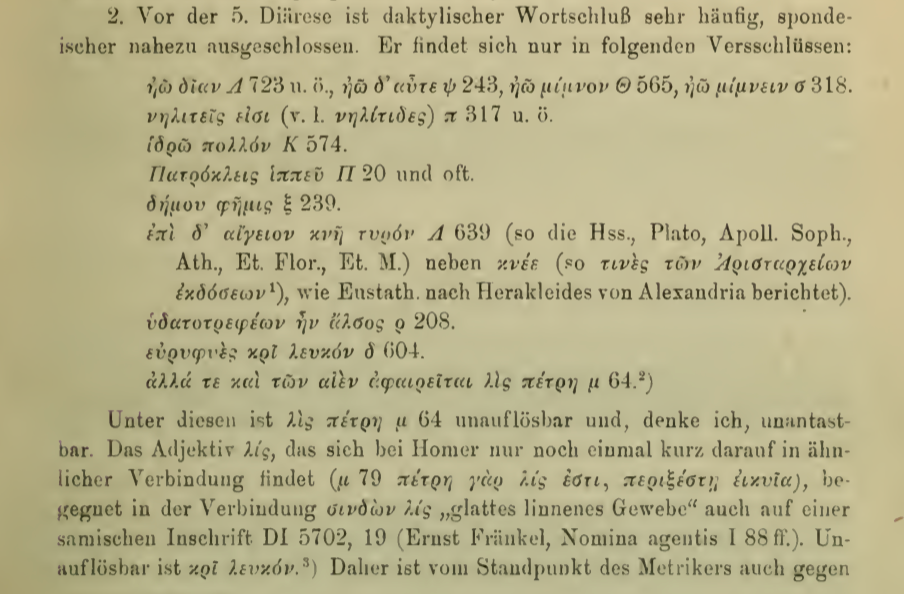

The actual figures are 26 x in 7974 instances of diaeresis in the I+O: frequency of 0.32%

Not in our edition:
Πατρόκλεις ἱππεῦ -->  Πατρόκλεες ἱππεῦ in the Hypo Edition and is not in our list.

1 lDll tlg001:8.565 ἑσταότες παρ’ ὄχεσφιν ἐΰθρονον Ἠῶ μίμνον.
2 lDll tlg001:9.240 ἀρᾶται δὲ τάχιστα φανήμεναι Ἠῶ δῖαν·
        Not in Meister 3 lDll tlg001:10.238 καλλείπειν, σὺ δὲ χείρον’ ὀπάσσεαι αἰδοῖ εἴκων
4 lDll tlg001:10.574 αὐτὰρ ἐπεί σφιν κῦμα θαλάσσης ἱδρῶ πολλὸν
5 lDll tlg001:11.639 οἴνῳ Πραμνείῳ, ἐπὶ δ’ αἴγειον κνῆ τυρὸν
6 lDll tlg001:11.723 ἐγγύθεν Ἀρήνης, ὅθι μείναμεν Ἠῶ δῖαν
7 lDll tlg001:18.255 ἄστυδε νῦν ἰέναι, μὴ μίμνειν ἠῶ δῖαν
8 lDll tlg002:4.604 πυροί τε ζειαί τε ἰδ’ εὐρυφυὲς κρῖ λευκόν.
9 lDll tlg002:9.151 ἔνθα δ’ ἀποβρίξαντες ἐμείναμεν Ἠῶ δῖαν.
10 lDll tlg002:9.306 ὣς τότε μὲν στενάχοντες ἐμείναμεν Ἠῶ δῖαν.
11 lDll tlg002:9.436 ὣς τότε μὲν στενάχοντες ἐμείναμεν Ἠῶ δῖαν.
12 lDll tlg002:12.7 ἔνθα δ’ ἀποβρίξαντες ἐμείναμεν Ἠῶ δῖαν.
13 lDll tlg002:12.64 ἀλλά τε καὶ τῶν αἰεὶ ἀφαιρεῖται λὶς πέτρη·
14 lDll tlg002:14.239 ἦεν ἀνήνασθαι, χαλεπὴ δ’ ἔχε δήμου φῆμις.
15 lDll tlg002:16.317 αἵ τέ σ’ ἀτιμάζουσι καὶ αἳ νηλιτεῖς εἰσιν·
16 lDll tlg002:16.368 νηῒ θοῇ πλείοντες ἐμίμνομεν Ἠῶ δῖαν,
17 lDll tlg002:17.208 ἀμφὶ δ’ ἄρ’ αἰγείρων ὑδατοτρεφέων ἦν ἄλσος,
18 lDll tlg002:18.318 ἤν περ γάρ κ’ ἐθέλωσιν ἐΰθρονον Ἠῶ μίμνειν,
19 lDll tlg002:19.342 ἄεσα καί τ’ ἀνέμεινα ἐΰθρονον Ἠῶ δῖαν.
20 lDll tlg002:22.418 αἵ τέ μ’ ἀτιμάζουσι καὶ αἳ νηλιτεῖς εἰσι.
21 lDll tlg002:23.243 νύκτα μὲν ἐν περάτῃ δολιχὴν σχέθεν, Ἠῶ δ’ αὖτε

Does Meister use a text that reads aidoi+ in tlg001:10.238?

## The 32 possible metrical variations of the hexameter

In [8]:
hextypes = {}

for boo in justscan_lines:
    foo = '\t'.join(justscan_lines[boo])
    if(foo in hextypes):
        hextypes[foo] = hextypes[foo] + 1
    else:
        hextypes[foo] =  1

i = 0
printlist = []
for foo in sorted(hextypes,key=hextypes.get,reverse=True):
    i = i + 1
    works,spondees = re.subn('(– –)','\g<1>',foo)
    totpercent = re.sub('(\.[0-9][0-9])[0-9]*','\g<1>',str(100*hextypes[foo]/(illinecnt+odlinecnt)) + '%')
    #print(i,hextypes[foo],totpercent,foo)
    printlist.append([i,str(spondees),hextypes[foo],totpercent,foo])
expectedtrocheelines = str(cumpercent*(illinecnt+odlinecnt))
expectedtrocheelines = re.sub('(\.[0-9]).+','\g<1>',expectedtrocheelines)

print()
print(tabulate(printlist,headers=['#','spondees','count','%','pattern']))
print('expected all-spondee lines',cumpercent,expectedtrocheelines)
print()
    



  #    spondees    count  %       pattern
---  ----------  -------  ------  ---------
  1           1     5376  19.34%  – ⏑ ⏑	– ⏑ ⏑	– ⏑ ⏑	– ⏑ ⏑	– ⏑ ⏑	– –
  2           2     4029  14.49%  – ⏑ ⏑	– –	– ⏑ ⏑	– ⏑ ⏑	– ⏑ ⏑	– –
  3           2     3583  12.89%  – –	– ⏑ ⏑	– ⏑ ⏑	– ⏑ ⏑	– ⏑ ⏑	– –
  4           2     2415  8.68%   – ⏑ ⏑	– ⏑ ⏑	– ⏑ ⏑	– –	– ⏑ ⏑	– –
  5           3     2177  7.83%   – –	– –	– ⏑ ⏑	– ⏑ ⏑	– ⏑ ⏑	– –
  6           3     1843  6.63%   – ⏑ ⏑	– –	– ⏑ ⏑	– –	– ⏑ ⏑	– –
  7           3     1713  6.16%   – –	– ⏑ ⏑	– ⏑ ⏑	– –	– ⏑ ⏑	– –
  8           2     1175  4.22%   – ⏑ ⏑	– ⏑ ⏑	– –	– ⏑ ⏑	– ⏑ ⏑	– –
  9           4     1034  3.72%   – –	– –	– ⏑ ⏑	– –	– ⏑ ⏑	– –
 10           3      931  3.34%   – ⏑ ⏑	– –	– –	– ⏑ ⏑	– ⏑ ⏑	– –
 11           3      809  2.91%   – –	– ⏑ ⏑	– –	– ⏑ ⏑	– ⏑ ⏑	– –
 12           3      399  1.43%   – ⏑ ⏑	– ⏑ ⏑	– –	– –	– ⏑ ⏑	– –
 13           4      367  1.32%   – –	– –	– –	– ⏑ ⏑	– ⏑ ⏑	– –
 14           2      300  1.07%   – ⏑ ⏑	– ⏑ ⏑	– ⏑ ⏑	– ⏑ ⏑	– –	– –
 15    

# Caesuras in Homeric Hexameter

Monro 367: There is nearly always a caesura in the third foot. Of the two caesuras the more frequent in this place is the trochaic (τομὴ κατὰ τρίτον τροχαῖον). \[**GRC**: 58\% in the Iliad and Odyssey both.\]

    ἄνδρα μοι ἔννεπε Μοῦσα | πολύτροπον ὃς μάλα πολλά
        
The strong caesura, or "caesura after the fifth half-foot" (τομὴ πενθημιμερής), is rather less common. \[**GRC**: 42\% in both the Iliad and the Odyssey.\]

    μῆνιν ἄειδε, θεά, | Πηληϊάδεω Ἀχιλῆος
    
In the first book of the Iliad, which contains 611 lines, the trochaic caesura of the third foot occurs in 356, and the corresponding strong caesura in 247. \[**Note**: In this calculation no lines are reckoned twice, short monosyllables being taken either with the preceding or the following wοrd, according to the sense.\]

In [9]:
caeslist = []
for foo in iliadcaesuras:
    ilpercent = re.sub('(\.[0-9][0-9])[0-9]*','\g<1>',str(100*iliadcaesuras[foo]/illinecnt) + '%')
    odpercent = re.sub('(\.[0-9][0-9])[0-9]*','\g<1>',str(100*odysseycaesuras[foo]/odlinecnt) + '%')
    caeslist.append([foo,iliadcaesuras[foo],ilpercent,odysseycaesuras[foo],odpercent,iliadcaesuras[foo]+odysseycaesuras[foo],caesurashapes[foo]])

print()
print(tabulate(caeslist,headers=['Caesura','Iliad','%','Odyssey','%','Total','Meter']))
print()




Caesura      Iliad  %         Odyssey  %         Total  Meter
---------  -------  ------  ---------  ------  -------  ----------------------------
caesmasc3     6643  42.36%       5171  42.70%    11814  – ⏔ – ⏔ – | ⏔ – ⏔ – ⏔ – –
caesfem3      8816  56.21%       6830  56.39%    15646  – ⏔ – ⏔ – ⏑ | ⏑ – ⏔ – ⏔ – –
caesmasc4      225  1.43%         113  0.93%       338  – ⏔ – ⏔ – ⏔ – | ⏔ – ⏔ – –
caesfem4       124  0.79%          98  0.80%       222  – ⏔ – ⏔ – ⏔ – ⏑ | ⏑  – ⏔ – –
nocaes           5  0.03%           0  0.0%          5  – ⏔ – ⏔ – ⏔ – ⏔ – ⏔ – –



# Monro 367: Caesura and Diaeresis

The division between an enclitic and the preceding word is not sufficient for the caesura in the third foot: hence in Od. 10.58 we should read

    αὐτὰρ ἐπεὶ σίτοιό τʼ | ἐπασσάμεθʼ ἠδὲ ποτῆτος

not σίτοιό τε πασσάμεθʼ (as La Roche).

The remaining exceptions to these rules are

    Il. 1.179 οἴκαδ’ ἰὼν σὺν νηνυσί τε σῇς καὶ σοῖς ἑτάροισι

which is an adaptation of the (probably conventional) form σὺν νηΐ τʼ ἐμῇ καὶ ἐμοῖς ἑτάροισι (Il. 1.183). We may help the rhythm by taking νηυσί τε σῇς closely together, so as to avoid the break in the middle of the line.

    Il. 3.205 ἤδη γὰρ καὶ δεῦρό ποτʼ ἤλυθε δῖος Oδυσσεύς
    Il. 10.453 οὐκέτʼ ἔπειτα σὺ πῆμά ποτʼ ἔσσεαι Ἀργείοισι

Where ποτέ, as an enclitic, is in an unusual place in the sentence (§ 365.4), but it is perhaps in reality an emphatic "one day." Similarly, in

    Il. 3.220 φαίης κε ζάκοτόν τέ τινʼ ἔμμεναι ἄφρονά τʼ αὔτως

τινα may be slightly emphatic. Or should we read τὸν ἔμμεναι?

    Il. 15.18 ἢ οὐ μέμνῃ ὅτε τʼ ἑκρέμω ὑψόθεν, ἕκ τε ποδοῖϊν

We may read ὅτε τε κρέμω: but possibly the peculiar rhythm is intentional, as being adapted to the sense.

In [10]:
print('Lines with no caesura detected')
for foo in caesuraexamples['nocaes']:
    print(foo,full_lines[foo])
    print(foo,meter_lines[foo],'\n')
print('\n')


Lines with no caesura detected
tlg001:3.205 ἤδη γὰρ καὶ δεῦρό ποτ’ ἤλυθε δῖος Ὀδυσσεὺς
tlg001:3.205 long-ἤδ-long-η γ-long-ὰρ κ-long-αὶ δ-long-εῦρ-short-ό π-short-οτ’ long-ἤλ-short-υθ-short-ε δ-long-ῖ-short-ος short-Ὀδ-long-υσσ-long-εὺς 

tlg001:3.220 φαίης κε ζάκοτόν τέ τιν’ ἔμμεναι ἄφρονά τ’ αὔτως.
tlg001:3.220 long-φαί-long-ης κ-long-ε ζ-short-άκ-short-οτ-long-όν τ-short-έ τ-short-ιν’ long-ἔμμ-short-εν-short-αι long-ἄφρ-short-ον-short-ά τ’ long-αὔτ-long-ως 

tlg001:10.453 οὐκέτ’ ἔπειτα σὺ πῆμά ποτ’ ἔσσεαι Ἀργείοισιν.
tlg001:10.453 long-οὐκ-short-έτ’ short-ἔπ-long-ειτ-short-α σ-short-ὺ π-long-ῆμ-short-ά π-short-οτ’ long-ἔσσ-short-ε-short-αι long-Ἀργ-long-εί-long-οισ-long-ιν 

tlg001:15.18 ἦ οὐ μέμνῃ ὅτε τ’ ἐκρέμω ὑψόθεν, ἐκ δὲ ποδοῖιν
tlg001:15.18 long-ἦ οὐ μ-long-έμν-long-ῃ short-ὅτ-short-ε τ’ long-ἐκρ-short-έμ-short-ω long-ὑψ-short-όθ-short-εν long-ἐκ δ-short-ὲ π-short-οδ-long-οῖ-long-ιν 

tlg001:23.668 ἡμίονον δ’ οὔ φημί τιν’ ἀξέμεν ἄλλον Ἀχαιῶν
tlg001:23.668 long-ἡμ-short-ί-short-

# Discrepancies between the automatic scan and what Monro reports

The algorithm detected four the five lines that have no caesura if we bind enclitics to the words that precede them.

    tlg001:3.205 ἤδη γὰρ καὶ δεῦρό ποτ’ ἤλυθε δῖος Ὀδυσσεὺς
    tlg001:10.453 οὐκέτ’ ἔπειτα σὺ πῆμά ποτ’ ἔσσεαι Ἀργείοισιν.
    tlg001:3.220 φαίης κε ζάκοτόν τέ τιν’ ἔμμεναι ἄφρονά τ’ αὔτως.
    tlg001:15.18 ἦ οὐ μέμνῃ ὅτε τ’ ἐκρέμω ὑψόθεν, ἐκ δὲ ποδοῖιν


## A line that the algorithm does not extract because a different reading was used

The Hypotactica edition does indeed follow the reading that Monro recommends:
    
    Od. 10.58 we should read: αὐτὰρ ἐπεὶ σίτοιό τʼ | ἐπασσάμεθʼ ἠδὲ ποτῆτος

And so Od. 10.58 does have a caesura and does not show up in our automatically generated list.

## A line in Monro that our algorithm attributes a caesura 

There was one case where the algorithm attributed a caesura (masculinein the fourth foof) where Monro did not:

    Il. 1.179 οἴκαδ’ ἰὼν σὺν νηνυσί τε σῇς καὶ σοῖς ἑτάροισι
    
The algorithm does not track the fact that the καὶ follows and augments a τε two words behind and so allows for a caesura. **Should we check for τε ... καὶ and not allow for caesura before καὶ in such a case? The Treebank should let us determine if there is a te associated with the kai and --> not to allow a caesura before this kai.**


## Automatically extracted line that does not show up in Monro

The one line that the algorithm extracted that does not show up in Monro is:

    tlg001:23.668 ἡμίονον δ’ οὔ φημί τιν’ ἀξέμεν ἄλλον Ἀχαιῶν
    long-ἡμ-short-ί-short-ον-long-ον δ’ long-οὔ long-φημ-short-ί τ-short-ιν’ long-ἀξ-short-έμ-short-εν long-ἄλλ-short-ον short-Ἀχ-long-αι-long-ῶν 
    
I don't know why this slips past Monro but it does not seem to have a caesura to me if we take φημί τιν’ together -- I don't see how we do not, if we are binding enclitics tothe previous word.



In [11]:
otherlist = []
for foo in ilother:
    otherlist.append([foo,ilother[foo],odother[foo]])
print(tabulate(otherlist,headers=['Feature','Iliad','Odyssey']))


Feature        Iliad    Odyssey
-----------  -------  ---------
long2short      3684       3151
short2long       397        307
hiatus           930        800
shortdouble      258        353
shorttriple        3          1
noelis           876        830
synizesis        167        163


In [12]:
caeslist = []
for foo in ildiaereses:
    print(foo)
    ilpercent = re.sub('(\.[0-9][0-9])[0-9]*','\g<1>',str(100*ildiaereses[foo]/illinecnt) + '%')
    odpercent = re.sub('(\.[0-9][0-9])[0-9]*','\g<1>',str(100*oddiaereses[foo]/odlinecnt) + '%')
    caeslist.append([foo,ildiaereses[foo],ilpercent,oddiaereses[foo],odpercent,ildiaereses[foo]+oddiaereses[foo],diaeresisshapes[foo]])

print()
print(tabulate(caeslist,headers=['Diaeresis','Iliad','%','Odyssey','%','Total','Meter']))
print()


diaer2
diaer3
diaer4
bucdiaer
diaer6

Diaeresis      Iliad  %         Odyssey  %         Total  Meter
-----------  -------  ------  ---------  ------  -------  -------------------------
diaer2          7004  44.66%       5504  45.45%    12508  – ⏔ | – ⏔ – ⏔ – ⏔ – ⏔ – –
diaer3          2939  18.74%       2623  21.65%     5562  – ⏔ – ⏔ | – ⏔ – ⏔ – ⏔ – –
diaer4          2239  14.27%       1652  13.64%     3891  – ⏔ – ⏔ – ⏔ | – ⏔ – ⏔ – –
bucdiaer        9141  58.28%       6841  56.49%    15982  – ⏔ – ⏔ – ⏔ – ⏔ | – ⏔ – –
diaer6          4491  28.63%       3483  28.76%     7974  – ⏔ – ⏔ – ⏔ – ⏔ – ⏔ | – –



In [13]:
short2longinword = {}
short2longbeforeword = {}

short2longforminword = {}
short2longformbeforeword = {}

for i in range(0,len(all_words)):
    if(re.search('short2long',all_words[i])):
        m = re.search('short2long[0-9]:(.+)',all_words[i])
        curtype = m[1]
        args1 = all_words[i].split()
        args2 = all_words[i+1].split()
        if(re.search('short2long1',all_words[i])):
            curform = re.sub('(·|·|,|\.$)','',args1[1])
            curkey = args1[0]+'\t'+curform
            if(curform in short2longforminword):
                short2longforminword[curform] = short2longforminword[curform] + 1
            else:
                short2longforminword[curform] = 1

            if(curkey in eachform2lemma):
                lemma = eachform2lemma[curkey]
            else:
                if(curform in form2lemmas):
                    lemma = form2lemmas[curform]
                else:
                    lemma = 'nolem'
            if(lemma in short2longinword):
                short2longinword[lemma] = short2longinword[lemma] + 1
            else:
                short2longinword[lemma] =  1
                
            #print(args1[0],args1[1],lemma,curtype)
        else:
            curform = re.sub('(·|·|,|\.$)','',args2[1])
            curkey = args1[0]+'\t'+curform
            curkey = re.sub('(·|·|,|\.$)','',curkey)

            if(curkey in eachform2lemma):
                lemma = eachform2lemma[curkey]
            else:
                if(curform in form2lemmas):
                    lemma = form2lemmas[curform]
                else:
                    lemma = 'nolem'
            if(curform in short2longformbeforeword):
                short2longformbeforeword[curform] = short2longformbeforeword[curform] + 1
            else:
                short2longformbeforeword[curform] = 1
            if(lemma in short2longbeforeword):
                short2longbeforeword[lemma] = short2longbeforeword[lemma] + 1
            else:
                short2longbeforeword[lemma] =  1
            #print(args1[0],args1[1],args2[1],lemma,curtype)
            
lemmaindex['nolem'] = []
lemmacnt['nolem'] = 0
print('short2longbeforeword')
for foo in sorted(lemmacnt):
#for foo in sorted(lemmacnt,key=lemmacnt.get,reverse=True):
#for foo in sorted(short2longbeforeword,key=short2longbeforeword.get,reverse=True):
    if(not  foo[0] == 'μ'):
        continue
    if(foo in short2longbeforeword):
        curcnt = short2longbeforeword[foo]
    else:
        curcnt = 0
    print(foo,curcnt,lemmacnt[foo])
    
print()
print('short2longinword')

for foo in sorted(short2longinword,key=short2longinword.get,reverse=True):
    print(foo,short2longinword[foo])
    
    

print('short2longbeforeword')
for foo in sorted(short2longbeforeword):
    print(foo,short2longbeforeword[foo],len(lemmaindex[foo]))
    
print()
print('short2longinword')

for foo in sorted(short2longinword):
    print(foo,short2longinword[foo],len(lemmaindex))
            

short2longbeforeword
μά 0 4
μάκαπ 0 1
μάκαρ 0 42
μάκελλα 0 1
μάλα 3 531
μάλιστα 0 85
μάντις 0 17
μάργος 0 3
μάρμαρος 0 3
μάρναμαι 0 56
μάρπτω 2 16
μάρτυρος 0 8
μάσσω 0 1
μάσσων 0 1
μάσταξ 0 3
μάστιξ 6 22
μάστις 0 2
μάχαιρα 0 4
μάχη 0 134
μάχομαι 1 247
μάψ 0 9
μέγαρον 122 299
μέγαρόνδε 0 3
μέγας 91 729
μέγεθος 5 10
μέδομαι 0 15
μέδω 0 1
μέδων 0 25
μέθημαι 0 1
μέθυ 0 17
μέλαθρον 0 8
μέλαινα 0 2
μέλας 0 181
μέλδομαι 0 1
μέλεος 0 5
μέλι 0 7
μέλινος 1 14
μέλισσα 0 3
μέλλω 0 88
μέλος 5 24
μέλπηθρα 0 3
μέλπω 0 5
μέλω 0 63
μέμαα 1 115
μέμονα 0 13
μέν 0 1872
μένος 0 183
μένω 0 183
μέρμερος 0 6
μέρμις 0 1
μέροπες 0 1
μέροψ 0 10
μέσαυλος 0 5
μέσος 0 145
μέσσατος 0 2
μέσφα 0 1
μέτασσα 0 1
μέτειμι 0 18
μέτρον 0 14
μέτωπον 0 12
μέχρι 0 2
μή 1 614
μήδομαι 0 34
μήκιστος 0 4
μήκων 0 1
μήλωψ 0 1
μήν 0 34
μήνη 0 2
μήνιμα 0 2
μήποτε 0 1
μήρινθος 0 5
μήστωρ 0 17
μήτε 0 37
μήτηρ 1 210
μήτρως 0 2
μίγδα 0 2
μίγνυμι 0 81
μίμνω 0 50
μίνυνθα 0 14
μίσγω 0 1
μίτος 0 1
μίτρα 0 4
μαίνομαι 0 23
μαίομαι 0 3
μαιμάω 0 6

In [14]:
import re
equivwords = {}
equivwordcnts = {}

for foo in all_words:
    args = foo.split()
    curpos = ''
    curform = re.sub('(·|·|,|\.$)','',args[1])
    curkey = args[0] + '\t' + curform
    meterkey = args[4]
    meterkey = re.sub('[^longshort\-]+','',meterkey)
    meterkey = re.sub('(^-|-$)','',meterkey)
    meterkey = re.sub('--','-',meterkey)
    
    if(curkey in eachform2lemma):
        lemma = eachform2lemma[curkey]
        curpos = eachform2pos[curkey]
    else:
        if(curform in form2lemmas):
            lemma = form2lemmas[curform]
            curpos = form2lemmas[curform]
        else:
            lemma = 'nolem'
            lemma = 'nopos'
    #if(not re.search('^a',curpos)):
    #if(not re.search('^v-..p',curpos)):
    #if(not re.search('v[3]s',curpos)):
    if(not re.search('^a-s---.g-',curpos)):
        continue
    #if( not curform[0].isupper()):
    #    continue
    #print(curkey,meterkey,curpos,lemma)
    usekey = curpos + '\t' + curform + '\t' +  lemma
    if(meterkey in equivwords):
        templist = equivwords[meterkey]
        if(not usekey in templist):
            equivwordcnts[meterkey] = equivwordcnts[meterkey] + 1
            templist.append(usekey)
            equivwords[meterkey] = templist
    else:
        equivwords[meterkey] = [usekey]
        equivwordcnts[meterkey] = 1
        
        
i = 0
for foo in sorted(equivwordcnts,key=equivwordcnts.get,reverse=True):
    i = i + 1
    print(i,foo,len(equivwords[foo]))
    if(i>20):
        break
    

1 long-short-short-long-long 63
2 short-short-long 52
3 long-long 51
4 short-long-long 40
5 long-short-short-long 38
6 short-short-long-short-short 35
7 short-long-short-short 31
8 long-long-long 27
9 short-short-long-short 25
10 short-short-long-long 24
11 long-short-short-long-short 23
12 long-short-short 21
13 short-long-short-short-long 16
14 long-long-long-long 16
15 long-long-short-short 16
16 short-long 15
17 short-long-long-long 15
18 long-short 14
19 long-long-short 13
20 short-long-long-long-short 12
21 long-long-long-short 10


In [15]:
for foo in sorted(equivwords['short-long-short-short']):
    args = foo.split()
    print(foo,lemmacnt[args[2]])

a-s----g-	δαΐφρονος	δαίφρων 59
a-s----g-	ἀμύμονος	ἀμύμων 116
a-s----g-	ἀνείμονος	ἀνείμων 1
a-s---fg-	νεουτάτου	νεούτατος 2
a-s---fg-	παλαιφάτου	παλαίφατος 3
a-s---fg-	πολυπτύχου	πολύπτυχος 4
a-s---fg-	ἀναιδέος	ἀναιδής 12
a-s---fg-	ἐπηράτου	ἐπήρατος 7
a-s---fg-	ἐυξόου	εὔξοος 17
a-s---fg-	ἐϋζύγου	εὔζυγος 2
a-s---fg-	ἰονθάδος	ἰονθάς 1
a-s---mg-	Καϋστρίου	Καύστριος 1
a-s---mg-	βαθυρρόου	βαθύρροος 5
a-s---mg-	δαΐφρονος	δαίφρων 59
a-s---mg-	δαήμονος	δαήμων 5
a-s---mg-	δυσηχέος	δυσηχής 10
a-s---mg-	θυώδεος	θυώδης 3
a-s---mg-	μελίφρονος	μελίφρων 11
a-s---mg-	περικλυτοῦ	περικλυτός 24
a-s---mg-	ποδώκεος	ποδώκης 29
a-s---mg-	πολυπτύχου	πολύπτυχος 4
a-s---mg-	πολύφρονος	πολύφρων 10
a-s---mg-	ἀμειλίχου	ἀμείλιχος 3
a-s---mg-	ἀμύμονος	ἀμύμων 116
a-s---mg-	ἀνάλκιδος	ἄναλκις 20
a-s---mg-	ἀπηνέος	ἀπηνής 11
a-s---mg-	ἐνηέος	ἐνηής 5
a-s---mg-	ἑκηβόλου	ἑκηβόλος 9
a-s---mg-	Ὀλυμπίου	Ὀλύμπιος 43
a-s---ng-	μυληφάτου	μυλήφατος 1
a-s---ng-	Ἀχαιικοῦ	Ἀχαιικός 7


In [16]:
from tabulate import tabulate
curlemma = 'εἶπον'
curlemma = 'δίδωμι'
curlemma = 'ἔρχομαι'
curlemma = 'οἶδα'
curlemma = 'παύω'
curlemma = 'ἵημι'

tenselist = {'present':'^v..p', 'future' : '^v..f', 'imperfect' : '^v..i', 'aorist':'^v..a','perfect':'^v..r', 'pluperfect' : '^v..l', 'futureperfect': '^v..t'}
voicelist = {'active' : '^v....a', 'passive' : '^v....p','middle' : '^v....m', 'middle-passive' : '^v....e'}
personlist = {'1st' : '^v1', '2nd' :'^v2', '3rd': '^v3'}
numberlist = {'singular' : '^v.s', 'dual' : '^v.d', 'plural':'^v.p'}
moodlist = {'indicative':'^v...i', 'subjunctive' : '^v...s', 'optative':'^v...o', 'imperative':'^v...m', 'infinitive':'^v...n', 'participle':'^v...p'}
genderlist = {'masculine':'m..$', 'feminine':'f..$', 'neuter':'n..$'}
caselist = {'nominative':'n.$','vocative':'v.$' ,'genitive':'g.$', 'dative':'d.$', 'accusative':'a.$'}

paradigmlist = []
persnumlist = []
for foo in voicelist:
    for boo in moodlist:
        for goo in tenselist:
            paradigm = foo + ' ' + boo + ' ' + goo
            #print(paradigm)
            paradigmlist.append(paradigm)

numbercasegenderlist = []

for foo in numberlist:
    for boo in caselist:
        for goo in genderlist:
            numbercasegenderlist.append(foo + ' ' + boo + ' ' + goo)
for foo in personlist:
    for boo in numberlist:
        persnum = foo + ' ' + boo
        persnumlist.append(persnum)

        
def getparadigm(form):
    rval = ''
   
    for foo in voicelist:
        if(re.search(voicelist[foo],form)):
            if(rval):
                rval = rval + ' ' + foo
            else:
                rval = foo
   
    for foo in moodlist:
        if(re.search(moodlist[foo],form)):
            if(rval):
                rval = rval + ' ' + foo
            else:
                rval = foo
                
    for foo in tenselist:
        if(re.search(tenselist[foo],form)):
            if(rval):
                rval = rval + ' ' + foo
            else:
                rval = foo
   
    return(rval)

def getpersonnumber(form):
    rval = ''
    for foo in personlist:
        if(re.search(personlist[foo],form)):
            if(rval):
                rval = rval + ' ' + foo
            else:
                rval = foo
    if(not rval):
        return('')
    
    for foo in numberlist:
        if(re.search(numberlist[foo],form)):
            if(rval):
                rval = rval + ' ' + foo
            else:
                rval = foo
    
   
    return(rval)
def getnumbercasegender(curkey):
    rval = ''
    form,curstring = curkey.split()
    
    for foo in numberlist:
        if(re.search(numberlist[foo],form)):
            if(rval):
                rval = rval + ' ' + foo
            else:
                rval = foo
    
    for foo in caselist:
        if(re.search(caselist[foo],form)):
            if(rval):
                rval = rval + ' ' + foo
            else:
                rval = foo
    
    for foo in genderlist:
        if(re.search(genderlist[foo],form)):
            if(rval):
                rval = rval + ' ' + foo
            else:
                rval = foo
   
    return(rval)

paradigmdict = {}
fullformdict = {}
fullformlist = {}

for foo in paradigmlist:
    paradigmdict[foo] = 0
    if(re.search('infinitive',foo)):
        fullformdict[foo] = 0
        fullformlist[foo ] = {}
        continue
    if(re.search('participle',foo)):    
        for goo in numbercasegenderlist:
            curkey = foo + ' ' + goo
            #print('curk',curkey)
            fullformdict[curkey] = 0
            fullformlist[curkey] = {}
        
    for goo in persnumlist:
        fullformdict[foo + ' ' + goo] = 0
        fullformlist[foo + ' ' + goo] = {}
    #paradigmdict[foo] = workdict

for foo in lemma2forms[curlemma]:
    
    paradigm = getparadigm(foo)
    if( paradigm in paradigmdict):
        paradigmdict[paradigm]  = paradigmdict[paradigm] + lemma2forms[curlemma][foo]
    else:
        print('failpa',paradigm,foo)
    if(re.search('infinitive',paradigm)):
        fullformdict[paradigm] = fullformdict[paradigm] + 1
        workdict = fullformlist[paradigm]
        workdict[foo] = lemma2forms[curlemma][foo]
        fullformlist[paradigm] = workdict
        continue
    if(re.search('participle',paradigm)):
        numbercasegender = getnumbercasegender(foo)
        curkey = paradigm + ' ' + numbercasegender
        if(curkey in fullformdict):
            fullformdict[curkey] = fullformdict[curkey] + 1
            workdict = fullformlist[curkey]
            workdict[foo] = lemma2forms[curlemma][foo]
            fullformlist[curkey] = workdict
            #print(foo,curkey,fullformdict[curkey])
        else:
            print('fail2',foo,curkey)
    personnumber = getpersonnumber(foo)
    if(personnumber):
        curkey = paradigm + ' ' + personnumber
        if(curkey in fullformdict):
            fullformdict[curkey] = fullformdict[curkey] + 1
            workdict = fullformlist[curkey]
            workdict[foo] = lemma2forms[curlemma][foo]
            fullformlist[curkey] = workdict
            #print(foo,curkey,fullformdict[curkey])
        else:
            print('fail1',foo,curkey)
    
    #print(foo,paradigm,personnumber)
    
print('\ntotals')

def adjslots(parads,paradindex):
    return

def persnumslots(paradslot,paradindex):
    curslots = ''
    curdict = fullformlist[paradslot + ' ' + persnumlist[paradindex]]
    for foo in sorted(curdict,key=curdict.get,reverse=True):
        baseform = re.sub('^[^\s]+\s','',foo)
        if curslots:
            curslots = curslots + '\n' + str(curdict[foo]) + ' ' + baseform 
        else:
            curslots = str(curdict[foo]) + ' ' + baseform 
    
    return(curslots)


def verbprintlist(paradslot):
    
    
    row1 = ['1st']
    
    curslots = persnumslots(paradslot,0)
    row1.append(curslots)
    
    curslots = persnumslots(paradslot,1)
    row1.append(curslots)
    
    curslots = persnumslots(paradslot,2)
    row1.append(curslots)
    
    
 
    row2 = ['2nd']
    curslots = persnumslots(paradslot,3)
    row2.append(curslots)
    
    curslots = persnumslots(paradslot,4)
    row2.append(curslots)
    
    curslots = persnumslots(paradslot,5)
    row2.append(curslots)
    

    row3 = ['3rd']
    curslots = persnumslots(paradslot,6)
    row3.append(curslots)
    
    curslots = persnumslots(paradslot,7)
    row3.append(curslots)
    
    curslots = persnumslots(paradslot,8)
    
    
    row3.append(curslots)
    
    
    

    print(tabulate([row1,row2,row3],headers=['person','singular','dual','pural']))

    
def numbercasegenderslots(paradslot,paradindex):
    curslots = ''
    curdict = fullformlist[paradslot + ' ' + numbercasegenderlist[paradindex]]
    for foo in sorted(curdict,key=curdict.get,reverse=True):
        baseform = re.sub('^[^\s]+\s','',foo)
        if curslots:
            curslots = curslots + '\n' + str(curdict[foo]) + ' ' + baseform 
        else:
            curslots = str(curdict[foo]) + ' ' + baseform 
    
    return(curslots)

def participlenumber(parads,startindex):
    singnommasc = numbercasegenderslots(parads,startindex)
    startindex = startindex + 1
    singnomfem = numbercasegenderslots(parads,startindex)
    startindex = startindex + 1
    singnomneut = numbercasegenderslots(parads,startindex)
    singnom = ["accusative", singnommasc,singnomfem,singnomneut]

    startindex = startindex + 1
    singvocmasc = numbercasegenderslots(parads,startindex)
    startindex = startindex + 1
    singvocfem = numbercasegenderslots(parads,startindex)
    startindex = startindex + 1
    singvocneut = numbercasegenderslots(parads,startindex)
    singvoc = ["vocative", singvocmasc,singvocfem,singvocneut]
    
    startindex = startindex + 1
    singgenmasc = numbercasegenderslots(parads,startindex)
    startindex = startindex + 1
    singgenfem = numbercasegenderslots(parads,startindex)
    startindex = startindex + 1
    singgenneut = numbercasegenderslots(parads,startindex)
    singgen = ["genitive", singgenmasc,singgenfem,singgenneut]
    
    startindex = startindex + 1
    singdatmasc = numbercasegenderslots(parads,startindex)
    startindex = startindex + 1
    singdatfem = numbercasegenderslots(parads,startindex)
    startindex = startindex + 1
    singdatneut = numbercasegenderslots(parads,startindex)
    singdat = ["dative", singdatmasc,singdatfem,singdatneut]
    
    startindex = startindex + 1
    singaccmasc = numbercasegenderslots(parads,startindex)
    startindex = startindex + 1
    singaccfem = numbercasegenderslots(parads,startindex)
    startindex = startindex + 1
    singaccneut = numbercasegenderslots(parads,startindex) #14
    singacc = ["accusative", singaccmasc,singaccfem,singaccneut]
    return([singnom,singvoc,singgen,singdat,singacc])

def participlelist(parads):
    print()
    print(parads)

    partlist = participlenumber(parads,0)
    print()
    print('Singular')
    print(tabulate(partlist,headers=['case','masculine','feminine','neuter']))
    
    partlist = participlenumber(parads,15)
    print()
    print('Dual')
    print(tabulate(partlist,headers=['case','masculine','feminine','neuter']))
    
    partlist = participlenumber(parads,28)
    print()
    print('Plural')
    print(tabulate(partlist,headers=['case','masculine','feminine','neuter']))

    #for foo in numbercasegenderlist:
    #    curkey = parads + ' ' + foo
    #    print(curkey,fullformlist[curkey])
        
for foo in sorted(paradigmdict,key=paradigmdict.get,reverse=True):
    if(not paradigmdict[foo]):
        continue
    
    print('\n')
    print(paradigmdict[foo],foo)
    #for i in range(0,9):
    #for boo in persnumlist:
    #    curkey = foo + ' ' + boo
    #    print(fullformlist[curkey])
    
    if(re.search('(infinitive)',foo)):
        curdict = fullformlist[foo]
        for boo in sorted(curdict,key=curdict.get,reverse=True):
            curform = re.sub('^[^\s]+\s+','',boo)
            print(curdict[boo],curform)
        continue
        
    if(re.search('participle',foo)):
        participlelist(foo)
        continue
    verbprintlist(foo)
    
    #print('1st',fullformlist[foo + ' ' + persnumlist[0]],fullformlist[foo + ' ' + persnumlist[1]],fullformlist[foo + ' ' + persnumlist[2]])
    #print('2nd',fullformlist[foo + ' ' + persnumlist[3]],fullformlist[foo + ' ' + persnumlist[4]],fullformlist[foo + ' ' + persnumlist[5]])
    #print('3rd',fullformlist[foo + ' ' + persnumlist[6]],fullformlist[foo + ' ' + persnumlist[7]],fullformlist[foo + ' ' + persnumlist[8]])
    #singrow = ['1st',curkey]
    
    
    


totals


60 active indicative aorist
person    singular    dual    pural
--------  ----------  ------  -------
1st       3 ἧκα
2nd
3rd       37 ἧκε              1 ἕσαν
          14 ἧκεν             1 ἧκαν
          2 ἧκ’
          1 ἕηκε
          1 ἧκέ


38 middle-passive participle present

middle-passive participle present

Singular
case        masculine    feminine    neuter
----------  -----------  ----------  --------
accusative  4 ἱέμενος    4 ἱεμένη
vocative
genitive    1 ἱεμένοιο
dative      1 ἱεμένῳ
accusative  4 ἱέμενον    1 ἱεμένην
            1 ἱέμενόν

Dual
case        masculine    feminine    neuter
----------  -----------  ----------  --------
accusative
vocative
genitive
dative
accusative  2 ἱεμένω

Plural
case        masculine    feminine    neuter
----------  -----------  ----------  ----------
accusative                           12 ἱέμενοι
                                     1 ἱέμενοί
vocative
genitive                             4 ἱεμένων
dative
accusative      

In [16]:
#!wget https://epigraphy.packhum.org/text/289?hs=5598-5607

f = open('289?hs=5598-5607')
    
for l in f:
    #print(l)
    searchs = 'Δ𐅃.+Σκιάθιοι'
    if(re.search(searchs,l)):
        print(l)
f.close()

Δ𐅃<span class="r">[𐅂ΙΙΙΙ]</span>     Σκιάθιοι



In [44]:
import pandas as pd
import plotly.express as px

numbers = {'s':'sing', 'd': 'dual', 'p':'plural','-':'noinfo','_':'noinfo'}
persons = {'1':'1st', '2': '2nd', '3':'3rd','-':'noinfo','_':'noinfo'}
tenses = {'p':'present','f':'future', 'i':'imperfect','a':'aorist','r':'perfect','l':'pluperfect','t':'future perfect','-':'noinfo','_':'noinfo'}
voices = {'a':'active','m':'middle','p':'passive', 'i':'imperfect','e':'middle-passive','-':'noinfo','_':'noinfo'}
moods = {'i':'indicative','s':'subjunctive', 'o':'optative','m':'imperative','p':'participle','n':'infinitive','-':'noinfo','_':'noinfo'}

def vizword(lem):
    formtable = []
    workdict = lemma2forms[lem]
    for foo in workdict:
        postag,curform = foo.split()
    #print(postag)
        posargs = re.search('^(.)(.)(.)(.)(.)(.)',postag)
    #print(posargs[2])
        formtable.append([persons[posargs[2]],numbers[posargs[3]],tenses[posargs[4]],moods[posargs[5]],voices[posargs[6]],curform,workdict[foo]])
#print(formtable)

    labels = ['person','number','tense','mood','voice','form','freq']
    df = pd.DataFrame(formtable,columns=labels)
#print(df)

    fig3x = px.treemap(df, path=[px.Constant(lem),'person','number', 'tense', 'mood','voice','form'], values='freq')
    fig3x.show()
    fig3y = px.treemap(df, path=[px.Constant(lem), 'tense', 'mood','voice','person','number','form'], values='freq')
    fig3y.show()
    fig3z = px.sunburst(df, path=[px.Constant(lem), 'tense', 'mood','voice','person','number','form'], values='freq')
    fig3z.show()
    
    
   
vizword('ἵημι')   
vizword('εἰμί')
vizword('ποιέω')